In [5]:
import numpy as np
import pandas as pd
import commonFunctions as func
import matplotlib.pyplot as plt
import folium
import plotly.graph_objects as go

In [6]:
# pinnaclePoints = pd.read_csv('../formattedSummits/pinnaclePoints_raw.txt', 
#                              sep = ',', 
#                              header = None,
#                              names = ['id', 'latitude', 'longitude', 'elevation', 'h_distance'])
# pinnaclePoints = pinnaclePoints[['latitude', 'longitude', 'elevation']]
# pinnaclePoints['prominence'] = pinnaclePoints.elevation
# pinnaclePoints['summit_name'] = ''
# pinnaclePoints['wikipedia'] = ''

pinnaclePoints = pd.read_csv('../pinnaclePoints.txt', sep=',').fillna('')

pinnaclePoints['elevationRank'] = pinnaclePoints.elevation.rank(ascending = False).astype(int)
pinnaclePoints['prominenceRank'] = pinnaclePoints.prominence.rank(ascending = False).astype(int)

faultyPinnacles = pd.read_csv('../misc/faultyPinnaclePoints.csv', sep=',').round(4)

In [7]:
def getPinnaclePointColor(elevation):
    if elevation >= 6000:
        return 'red'
    elif elevation >= 4000:
        return 'orange'
    elif elevation >= 2000:
        return 'yellow'
    else:
        return 'limegreen'
    
def addPointToMap(summit, isEasterEgg=False, extraToolTip='', overrideElevation=0):
    
    # adding a * for faulty pinnacle points
    faultyInd = ''
    if (summit.summit_name in faultyPinnacles.nameFalse.values 
        or (summit.latitude in faultyPinnacles.latFalse.values 
            and summit.longitude in faultyPinnacles.lngFalse.values)):
        faultyInd = '*'

    summitTitle = summit.summit_name + faultyInd
    summitTitleHTML = ''
    if summitTitle != '':
        summitTitleHTML = f'<b>{summitTitle}</b><br>'
        
    elevationRankText = ''
    prominenceRankText = ''
    if isEasterEgg == False:
        elevationRankText = f' [{summit.elevationRank}/601]'
        prominenceRankText = f' [{summit.prominenceRank}/601]'
 
    wikiHTML = ''
    if summit.wikipedia != '':
        wikiHTML = f'<a href=https://en.wikipedia.org/wiki/{summit.wikipedia.replace(" ","_")}>Wikipedia</a> | '
        
    latRounded = round(summit.latitude, 4)
    lngRounded = round(summit.longitude, 4)
    toolTip = (f'{summitTitleHTML}' + 
               f'Elevation: {round(summit.elevation)} m{elevationRankText}<br>' +
               f'Prominence: {round(summit.prominence)} m{prominenceRankText}<br>' + 
               f'Location: {latRounded}, {lngRounded}<br>' + 
               f'Link: {wikiHTML}' + 
               f'<a href=https://www.peakbagger.com/search.aspx?tid=R&lat={latRounded}&lon={lngRounded}&ss=>PeakBagger</a>')
    
    if isEasterEgg == True and extraToolTip != '':
        toolTip += f'<br><br>{extraToolTip}'
    
    markerAlpha = 1
    markerBorderColor = 'black'
    if isEasterEgg == True:
        markerAlpha = 0
        if overrideElevation > 0:
            markerBorderColor = getPinnaclePointColor(overrideElevation)
    
    marker = folium.RegularPolygonMarker(
        location = [summit.latitude, summit.longitude],
        number_of_sides=3,
        radius = 11,
        fill = True,
        fill_color = getPinnaclePointColor(summit.elevation),
        fill_opacity = markerAlpha,
        weight = 1,
        color = markerBorderColor,
        gradient = False,
        rotation = 30
    ).add_to(pinnaclePointMap)
    
    # for better usability on mobile
    invisibleCircle = folium.CircleMarker(
        location = [summit.latitude, summit.longitude],
        radius = 12,
        fill = True,
        fill_opacity = 0,
        weight = 0
    ).add_to(pinnaclePointMap)
    
    invisibleCircle.add_child(folium.Popup(toolTip, max_width=300).add_to(invisibleCircle))
    
summits = pinnaclePoints.sort_values('elevation', ascending=True)
pinnaclePointMap = folium.Map(location=[0, 0], zoom_start=3, tiles=None, world_copy_jump=True)

folium.raster_layers.TileLayer(name = 'Satellite',
                               maxZoom = 17,
                               tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 
                               attr = 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, GIS User Community'
                              ).add_to(pinnaclePointMap)
folium.TileLayer(
          'https://{s}.tile.opentopomap.org/{z}/{x}/{y}.png', 
          attr = 'Map data: &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors, <a href="http://viewfinderpanoramas.org">SRTM</a> | Map style: &copy; <a href="https://opentopomap.org">OpenTopoMap</a> (<a href="https://creativecommons.org/licenses/by-sa/3.0/">CC-BY-SA</a>)',
          name = 'Elevation',
          maxZoom = 16
          ).add_to(pinnaclePointMap)
folium.TileLayer(
          name = 'Street',
          ).add_to(pinnaclePointMap)

folium.LayerControl().add_to(pinnaclePointMap)

'''
Misidentifications Start
'''
faultData = []
summitCols = ['latitude', 
              'longitude', 
              'elevation', 
              'prominence', 
              'summit_name', 
              'wikipedia', 
              'elevationRank',
              'prominenceRank',
              'toolTip',
              'overrideElevation']

for i, fault in faultyPinnacles.iterrows():
    
    faultName = 'the other point'
    if not pd.isna(fault.nameFalse):
        faultName = fault.nameFalse
    
    faultReason = ''        
    if fault.reason == 0:
        faultReason = (f'{fault.nameTrue} is a pinnacle point,<br>' + 
                       'but Source 1 lists it as shorter<br>' + 
                       f'than {faultName} due to<br>' + 
                       'measurement error.')
    elif fault.reason == 1:
        faultReason = (f'{fault.nameTrue} is a pinnacle point,<br>' + 
                       'but it is missing from Source 1,<br>' + 
                       f'so {faultName} was<br>' + 
                       'identified instead.')
    
    newFault = [fault.latTrue, fault.lngTrue, fault.elevationTrue, fault.prominenceTrue,
                fault.nameTrue, '', '', '', faultReason, fault.elevationFalse]
    faultData.append(newFault)
    
    # Adding a line to the true summit for misidentifications
    faultToTrueLine = [[fault.latFalse, fault.lngFalse], [fault.latTrue, fault.lngTrue]]
    folium.PolyLine(faultToTrueLine, color=getPinnaclePointColor(fault.elevationFalse), weight=1, opacity=1).add_to(pinnaclePointMap)

faultData = pd.DataFrame(faultData, columns=summitCols)

faultData.apply(lambda summit: addPointToMap(summit, 
                                             isEasterEgg = True, 
                                             extraToolTip = summit.toolTip,
                                             overrideElevation = summit.overrideElevation), axis=1)
'''
Misidentifications End
'''

summits.apply(addPointToMap, axis=1)

legend_html = """
    <div style="
        background-color: rgba(255, 255, 255, 0.9);
        padding: 5px;
        font-size: 12px;
        position: absolute;
        top: 12px;
        right: 70px;
        z-index: 1000;
    ">
        <div style="display: flex; align-items: center; cursor: pointer;" title="Legend" onclick="toggleLegend()">
            <div id="chevronIcon" style="margin-left: 11px; margin-right: 15px; width: 10px; height: 10px; 
                border-style: solid; border-width: 0 2px 2px 0; transform: rotate(45deg);"></div>
            <h4 style="margin: 0; margin-right: 30px;">Pinnacle Points</h4>
        </div>
        <div id="legendContent" style="display: none; margin-top: 5px;">
            <center style="margin-top: 15px; margin-bottom: 15px;">
                A <b>pinnacle point</b> is a point<br>from which no higher point<br>can be seen [Count: 601]
            </center>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 4px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="limegreen" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">Elevation < 2000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 0px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="yellow" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">2000 m &le; Elevation < 4000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="orange" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">4000 m &le; Elevation < 6000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 16px; margin-right: 2px; margin-top: -4px">
                        <svg width="14" height="14">
                            <polygon points="0,14 7,1 14,14" fill="black" />
                            <polygon points="1.5,13 7,3.2 12.5,13" fill="red" />
                        </svg>
                    </div>
                    <div class="col">
                        <div class="col">Elevation &ge; 6000 m</div>
                    </div>
                </div>
            </p>
            <p style="margin: 0;">
                <div class="row">
                    <div class="col-1" style="margin-left: 20px; margin-right: 0px; margin-top: 1px">
                        <font size="4">*</font>
                    </div>
                    <div class="col">
                        <div class="col">Misidentified [Count: 27]<br>Read more in info section</div>
                    </div>
                </div>
            </p>
        </div>
    </div>

    <script>
        function toggleInfoWindow() {
            var infoWindow = document.getElementById("infoWindow");
            var infoIcon = document.getElementById("informationIcon");

            if (infoWindow.style.display === "block") {
                infoWindow.style.display = "none";
                infoIcon.style.fill = "rgba(255, 255, 255, 0.9)";
            } else {
                infoWindow.style.display = "block";
                infoIcon.style.fill = "rgba(255, 255, 0, 0.9)";
            }
        }
    </script>

    <script>
        function toggleLegend() {
            var contentDiv = document.getElementById("legendContent");
            var chevronIcon = document.getElementById("chevronIcon");

            if (contentDiv.style.display === "block") {
                contentDiv.style.display = "none";
                chevronIcon.style.transform = "rotate(45deg)";
            } else {
                contentDiv.style.display = "block";
                chevronIcon.style.transform = "rotate(225deg)";
            }
        }
    </script>
"""

pinnaclePointMap.get_root().html.add_child(folium.Element(legend_html))

pinnaclePointMap.get_root().html.add_child(folium.Element(f'''
    <div id="catalogue" style="position: absolute; bottom: 106px; right: 4px; cursor: pointer; z-index: 1001;">
        <a href="guide/index.html">
            <svg id="catalogueIcon" width="50" height="50" viewBox="0 0 50 50" fill="white" stroke="black"
                stroke-linecap="round" stroke-linejoin="round" style="fill: rgba(255, 255, 255, 0.9)">
                <title>Guide</title>
                <circle cx="24" cy="24" r="20" stroke-width="6" ></circle>
                <rect x="16" y="15" width="16" height="19" stroke-width="2" fill="none"></rect>
                <rect x="19" y="15" width="13" height="19" stroke-width="2" fill="none"></rect>
                <line x1="23" y1="21" x2="28" y2="21" stroke-width="2"></line>
            </svg>
        </a>
    </div>
'''))

pinnaclePointMap.get_root().html.add_child(folium.Element(f'''
    <div id="infoIcon" style="position: absolute; bottom: 12px; right: 0px; cursor: pointer; z-index: 1001;">
        <svg id="informationIcon" width="100" height="100" viewBox="0 0 50 50" fill="white" stroke="black" stroke-width="4" 
            stroke-linecap="round" stroke-linejoin="round" onclick="toggleInfoWindow()" style="fill: rgba(255, 255, 255, 0.9)">
            <title>Info</title>
            <circle cx="24" cy="24" r="20"></circle>
            <line x1="24" y1="32" x2="24" y2="24"></line>
            <line x1="24" y1="16" x2="24" y2="16"></line>
        </svg>
    </div>
    <div id="infoWindow" style="display: none; overflow-y: auto; position: absolute; top: 50%; left: 50%; 
        transform: translate(-50%, -50%); background-color: rgba(255, 255, 255, 0.9); padding: 12px; width: 95%; 
        height: 68%;  z-index: 1000;">
        
        <h2>Definitions</h2>
        <p>
            A <b>pinnacle point</b> is a point from which no higher point can be seen. Across the globe, 601 have been found. 
            These are all pinnacle points with more than 300 m of prominence. 
            The algorithm used for finding pinnacle points is outlined below, along with sources of error.
            The curvature of the Earth, atmospheric refraction, and local topography are taken into account.
            For more, refer to the <a href="guide/screens/what_is_pinnacle_point/index.html">What is a Pinnacle Point</a> page.</p>
        <p>
            The <b>prominence</b> of a point is the minimum vertical distance one must descend to reach a higher point.
            It can be thought of as how much a summit rises above its base, in a way.
        </p>
        <p>
            The <b>direct line of sight</b> is the straight line connecting 2 points.
        </p>
        <p>
            The <b>light path</b> is the bent path light takes in the atmosphere between 2 points as a result of refraction.
        </p>
        
        <h2>Sources</h2>
        <h4><a href="http://everymountainintheworld.com/">1. Mountains by Topographic Prominence</a></h4>
        <p>
            Thanks to Andrew Kirmse and the Prominence Group for finding 11,866,713 summits with a 
            prominence greater than 100 feet (~30 m).
        </p>
        <h4><a href="https://ototwmountains.com/">2. On-Top-Of-The-World Mountains</a></h4>
        <p>
            An on-top-of-the-world mountain (OTOTW) is a summit where no land rises 
            above the horizontal plane from the summit. 
            Since any land that rises above the horizontal plane would have higher elevation than the summit itself, if a summit 
            is not an OTOTW then it can't be a pinnacle point either. In other words, pinnacle points are a subset of 
            OTOTWs. Thanks to Kai Xu for finding 6,464 OTOTWs around the world. Andreas Geyer-Schulz deserves 
            mention as well for his <a href="https://nuntius35.gitlab.io/extremal_peaks/">extremal peaks</a>.
        </p>
        <h4><a href="https://aty.sdsu.edu/explain/atmos_refr/horizon.html">3. Atmospheric Refraction</a></h4>
        <p>
            Different layers of the atmosphere have different refractive indices due to varying temperatures and pressures. 
            Though the exact path light takes in the atmosphere depends on many factors, a ray's path can be 
            approximated as the arc of a circle with radius 7 times greater than Earth's.
        </p>
        
        <h2>Links</h2>
        <li>
            <a href="guide/index.html">
            My jornal of summitted pinnacle points</a>
        </li>
        <li>
            <a href="https://www.peakbagger.com/list.aspx?lid=-953487&cid=48550">
            Top 100 pinnacle points by elevation</a>
        </li>
        <li>
            <a href="https://www.peakbagger.com/list.aspx?lid=-953489&cid=48550">
            Top 100 pinnacle points by prominence</a>
        </li>
        <li>
            <a href="https://www.rhsoc.uk/blog/hill-list-updates/two-classification-criteria-for-the-hills-and-mountains-of-britain/">
            Article on OTOTWs and pinnacle points</a>
        </li>
        
        <h2>App Download</h2>
        <p>
            Since the app is only available by downloading the APK, only Android devices are currently supported. 
            I hope to have the app on both the Android and Apple app stores eventually.
            Follow these steps to get the app on your Android device:
            <ol>
                <li>Open <a href="https://github.com/jgbreault/PinnaclePoints/blob/main/misc/pinnaclePoints.apk">this page</a> 
                    on your Android device.</li>
                <li>Click the button that looks like [<b>...</b>] (three dots).</li>
                <li>Click [<b>Download</b>]. Open the APK on your phone when it is done downloading. 
                    You may get a message similar to "<i>For your security, 
                    your phone is not allowed to install apps from this source</i>". 
                    You'll have to go to your settings and allow unknown installs from this source.
                    Feel free to change it back afterwards.</li>
                <li>Click [<b>Install</b>].</li>
            </ol>
        </p>
        
        <h2>Misidentifications</h2>
        <p>
            There are 27 misidentified pinnacle points discovered so far. Each is marked with an asterisk (*) beside the name.
            The true pinnacle point will be nearby. If you think you found another misidentified pinnacle point, 
            please contact me (below).
        </p>
        <h4>Sources of Error</h4>
        <ol>
            <li>
                When the OTOTWs were found, all summits with less than 300 m of prominence were omitted. 
                This cutoff is carried forward to pinnacle points.
            </li>
            <li>
                The earth is approximated as a sphere instead of an ellipsoid. This is done for simpler math.
            </li>
            <li>
                Only 100 elevations are sampled when determining if two points have an unobstructed light path. 
                This can lead to points that can block the light path being missed. 
                By increasing the number of elevations sampled, more pinnacle points would be found.
            </li>
            <li>
                To take atmospheric refraction into account, light rays are approximated as arcs of circles. 
                The path light takes in the atmosphere is in fact much more complex and depends on many factors.
                Note, since the distance you can see from a given point depends on temperature and pressure, 
                the distance you can see technically changes with the seasons and even the time of day. 
                Additionally, some assumptions used to take atmospheric refraction into account only hold true 
                for heights small compared to the 8 km height of the 
                <a href="https://aty.sdsu.edu/explain/thermal/hydrostatic.html#homog">homogeneous atmosphere</a>. 
                This project is slightly outside of this scope.
            </li>
            <li>
                There is some inherent error in the data. The datasets have a resolution of 30 m (1 arcsecond), 
                and the elevation API uses 90 m (3 arcseconds). All data sources are surface elevation models, 
                so trees and buildings are included.
            </li>
        </ol>

        <h2>Algorithms</h2>
        <h4>Finding Pinnacle Points</h4>
        <ol>
            <li>
                Categorize the 11,866,713 summits into patches based on longitude and latitude. 
                This is done for faster processing later. The patch size is 10 deg x 10 deg with some extra to take into account
                the fact that summits may be able to see beyond the patch they are in.
            </li>
            <li>
                Find the maximum horizon distance (MHD) defined as √(2*(7/6)*R_earth*Elevation) for each summit and OTOTW. 
                The factor of 7/6 is to account for atmospheric refraction increasing the distance that can be seen.
            </li>
            <li>
                Define a list of remaining OTOTWs as the full list of OTOTWs.
            </li>
            <li>
                Find the highest elevation remaining OTOTW (HERO).
            </li>
            <li>
                Find all other remaining OTOTWs where the sum of the OTOTW's MHD and the HERO's MHD 
                is greater than the distance between them. In other words, find all OTOTWs that have a chance 
                of being seen by the HERO. For each, do light path analysis (described below) to find which OTOTWs 
                can actually be seen by the HERO. Each will have a lower elevation than the HERO, so they are removed from the 
                list of remaining OTOTWs.
            </li>
            <li>
                Find the HERO's patch.
            </li>
            <li>
                Find all summits in the patch where both the summit's elevation is greater than the HERO's elevation 
                and the sum of the summit's MHD and the HERO's MHD is greater than the distance between them. In other 
                words, find all summits that have a chance of disqualifying the HERO from being a pinnacle point. For each, 
                do light path analysis to determine if any summits can actually see the HERO. If any can, the HERO is 
                not a pinnacle point and is removed from the list of remaining OTOTWs. Otherwise, the HERO is a pinnacle 
                point and is added to a list.
            </li>
            <li>
                Repeat 4-8 until there are no remaining OTOTWs.
            </li>
        </ol>
        <h4>Light Path Analysis</h4>
        <ol>
            <li>
                Generate a list of 100 equidistant latitude-longitude points between the two input points 
                along the geodesic.
            </li>
            <li>
                Find the elevation of each point using an 
                API (<a href="https://open-meteo.com/en/docs/elevation-api">Open-Meteo</a>), 
                and find the distance of each point to the first point.
            </li>
            <li>
                Translate each distance-elevation point such that the first point is at (0, 0).
            </li>
            <li>
                Apply a translation to each distance-elevation point based on how far away the 
                point is to take the curvature of the earth into account 
                (<a href="https://github.com/jgbreault/PinnaclePoints/blob/main/misc/math/earthCurvature.png">Curavture Math</a>).
            </li>
            <li>
                Rotate the points to make the last point at the 0 elevation line. In other words, 
                make direct line of sight along the x-axis 
                (<a href="https://github.com/jgbreault/PinnaclePoints/blob/main/misc/math/earthCurvature.png">Curavture Math</a>).
            </li>
            <li>
                Find the light path's distance above direct line of sight for each point 
                (<a href="https://github.com/jgbreault/PinnaclePoints/blob/main/misc/math/atmosphericRefraction.jpg">Refraction Math</a>).
            </li>
            <li>
                If any of the points are of greater elevation than the light path, 
                the light path is blocked. Otherwise, there is an unobstructed light path.
            </li>
        </ol>
        
        <h2><a href="guide/screens/contact/index.html">Contact</a></h2>
        <p>
            Contact me at jamiegbreault@gmail.com. 
            Read about my personal adventures to pinnacle points 
            <a href="guide/index.html">here</a>. I include tips for summitting them yourself.
            Check out the latest on <a href="https://github.com/jgbreault/PinnaclePoints">my github</a>. 
            There you will find a txt file of all 601 pinnacle points, the algorithm used, 
            and derivations of some of the math.
        </p>
        </br></br>
    </div>
'''))

pinnaclePointMap

In [7]:
pinnaclePointMap.save('../index.html')

In [4]:
summitPatches = func.getSummitPatches(printInfo=False)

Higher Summits to Test Sight: 669
49.06441, -55.878074 at 569 m is in view of 
49.0261, -56.8194 at 610.31 m (1 summits tested)
69 km away


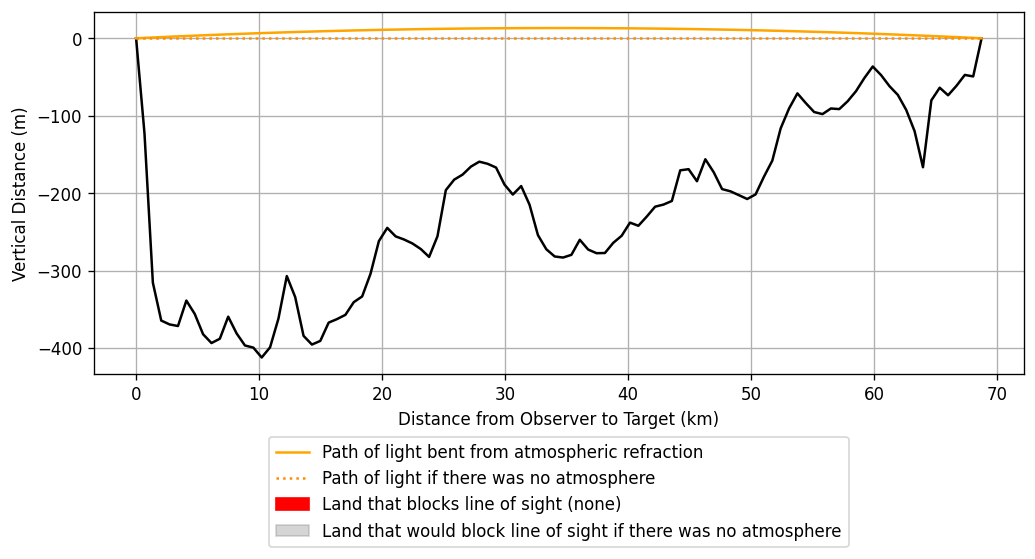

In [5]:
'''
Determines if a summit is a pinnacle point
Plots light path to closest higher summit if not a pinnacle point
The summit doesn't need to be in any of my datasets
'''
def isPinnaclePointLatLng(lat, lng, elevation=None):
    
    if elevation == None:
        elevation = func.getElevation(lat, lng)[0]
            
    summit = [0, # ID, set arbitrarily since not used
              lat,
              lng,
              elevation,
              func.horizonDistance(elevation)]
    
    patchSummits = func.getPatchSummits(lat, lng, summitPatches)
    
    func.isPinnaclePoint(summit, patchSummits, plotClosestInfo=True, testingCustomPoint=True)

isPinnaclePointLatLng(49.06441, -55.878074, 569)

Light Path: Yes
Direct Line of Sight: No
Distance: 538 km


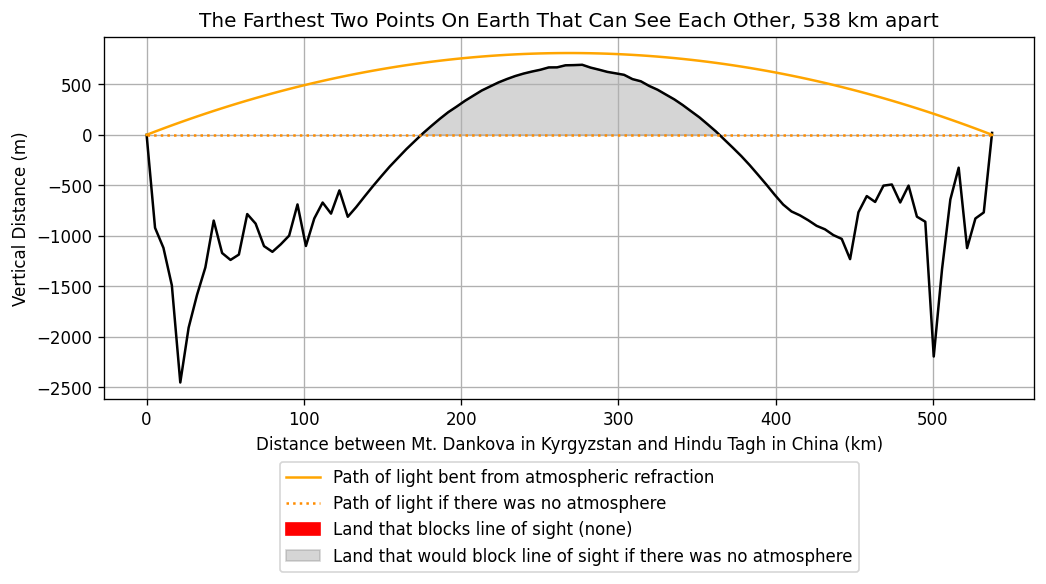

In [8]:
# testing longest line of sight on earth (538 km)
func.plotLosElevationProfile(41.0593, 77.68419, 
                             5982, 
                             36.295306, 78.755049, 
                             6421,
                             savePlot = True,
                             plotTitle = 'The Farthest Two Points On Earth That Can See Each Other, 538 km apart',
                             xLabel = 'Distance between Mt. Dankova in Kyrgyzstan and Hindu Tagh in China (km)')

In [8]:
# validating points omitted because of atmospheric refraction
def plotClosestLightPath(summit):
    patchSummits = func.getPatchSummits(summit[func.LAT], summit[func.LNG], summitPatches)
    return func.isPinnaclePoint(summit, patchSummits, plotClosestInfo=True)

pinnaclePointsDLOS = pd.read_csv('../dataSources/pinnaclePointsDLOS.txt', sep=',').fillna('')

omittedPinnaclePointsDLOS = pd.merge(pinnaclePointsDLOS, pinnaclePoints, on=['latitude', 'longitude', 'elevation'], how='left', indicator=True)
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS[omittedPinnaclePointsDLOS['_merge'] == 'left_only']
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS.drop('_merge', axis=1)
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS[['latitude', 'longitude', 'elevation']]
omittedPinnaclePointsDLOS['h_distance'] = omittedPinnaclePointsDLOS.elevation.apply(func.horizonDistance).round(1)
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS.reset_index()

# Not sure why this guy wasn't getting caught
omittedPinnaclePointsDLOS = omittedPinnaclePointsDLOS.query('latitude != 41.9991 and longitude != -74.3860')

# placeHolder = omittedPinnaclePointsDLOS.apply(plotClosestLightPath, axis=1)